In [72]:
from matplotlib import pyplot as plt
import sys
import requests
import base64
import json
from pprint import pprint
from dotenv import load_dotenv
import os

sys.path.append('../../..')
from hydradx.model.processing import query_sqlPad
time_range = ('2024-01-03T00:00:00.000Z', '2024-01-04T00:00:00.000Z')

In [109]:
query = f"""
WITH fees AS (
    SELECT 
        timestamp,
        block,
        operation,
        (asset_fee / NULLIF(amount, 0)) * 100 AS asset_fee_rate,
        (protocol_fee / NULLIF(amount, 0)) * 100 AS protocol_fee_rate,
        tm_in.symbol AS asset_in_symbol,
        tm_out.symbol AS asset_out_symbol,
        amount,
        amount_in,
        asset_fee,
        protocol_fee,
        tm_in.decimals AS asset_in_decimals,
        tm_out.decimals AS asset_out_decimals
    FROM (
        SELECT 
            timestamp, 
            block.height AS block, 
            args->>'who' AS who, 
            name AS operation, 
            (args->>'assetIn')::integer AS asset_in, 
            (args->>'assetOut')::integer AS asset_out, 
            (args->>'assetFeeAmount')::numeric AS asset_fee, 
            (args->>'protocolFeeAmount')::numeric AS protocol_fee, 
            (args->>'amountOut')::numeric AS amount, 
            (args->>'amountIn')::numeric AS amount_in
        FROM event 
        INNER JOIN block ON block_id = block.id 
        WHERE name = 'Omnipool.SellExecuted'
        ORDER BY block_id ASC
    ) AS trades
    LEFT JOIN token_metadata tm_in ON trades.asset_in = tm_in.id
    LEFT JOIN token_metadata tm_out ON trades.asset_out = tm_out.id
)
SELECT * FROM fees 
WHERE asset_out_symbol = 'DOT' 
  AND "timestamp" BETWEEN '{time_range[0]}' AND '{time_range[1]}'
ORDER BY 1
"""

In [110]:
# print(query)
fee_data = await query_sqlPad(query)
print("done")

waiting for query to finish...
done


In [115]:
query = f"""
WITH normalized_trades AS (
  SELECT
    timestamp,
    block,
    who,
    operation,
    (SELECT symbol FROM token_metadata WHERE id = asset_in LIMIT 1) AS asset_in,
    (SELECT symbol FROM token_metadata WHERE id = asset_out LIMIT 1) AS asset_out,
    amount_in / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_in LIMIT 1)) AS amount_in,
    amount_out / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS amount_out
  FROM (
    SELECT
      timestamp,
      block.height AS block,
      args->>'who' AS who,
      name AS operation,
      (args->>'assetIn')::integer AS asset_in,
      (args->>'assetOut')::integer AS asset_out,
      (args->>'amountIn')::numeric AS amount_in,
      (args->>'amountOut')::numeric AS amount_out
    FROM event
    INNER JOIN block ON block_id = block.id
    WHERE name LIKE 'Omnipool.%Executed'
      AND "timestamp" BETWEEN '{time_range[0]}' AND '{time_range[1]}'
  ) AS trades
),
trades AS (
  SELECT
    timestamp,
    block,
    amount_in / amount_out AS price,
    amount_in as amount,
    'buy HDX' as direction
  FROM normalized_trades
  WHERE asset_in = 'USDT' AND asset_out = 'DOT'
  UNION ALL
  SELECT
    timestamp,
    block,
    amount_out / amount_in AS price,
    amount_out as amount,
    'sell HDX' as direction
  FROM normalized_trades
  WHERE asset_in = 'DOT' AND asset_out = 'USDT'
)
SELECT
  timestamp AS "time",
  block,
  price,
  amount,
  direction 
FROM trades 
ORDER BY 1;
"""
# print(query)
price_data = await query_sqlPad(query)
print("done.")

waiting for query to finish...
done.


In [116]:
def oraclize(raw_data, length = 10):
    decay_factor = 2 / (length + 1)
    oracle_current = raw_data[0]
    oracle_values = [oracle_current]
    for item in raw_data[1:]:
        oracle_current = oracle_current * (1 - decay_factor) + item * decay_factor
        oracle_values.append(oracle_current)
    return oracle_values

def fill_block_prices(price_data):
    block_prices = {line[1]: line[2] for line in price_data}
    min_block = min(block_prices)
    max_block = max(block_prices)
    
    last_price = None
    return [(block, block_prices.get(block, last_price := block_prices.get(block, last_price))) for block in range(min_block, max_block + 1)]


Text(0, 0.5, 'DOT asset fee')

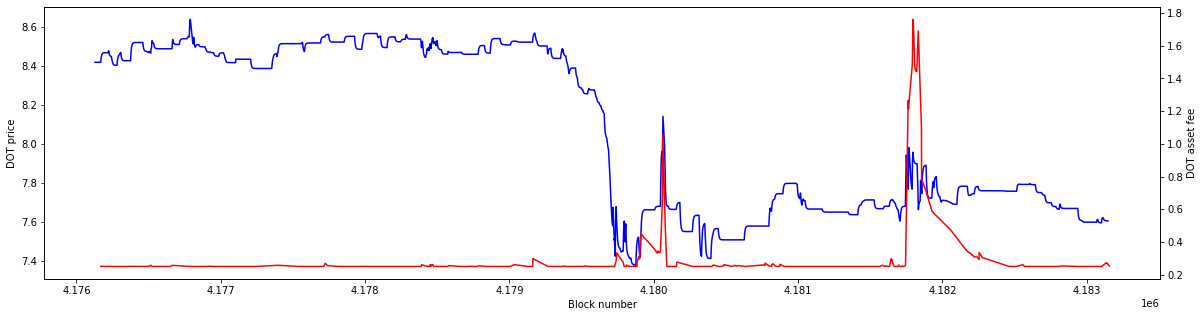

In [117]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
price_per_block = fill_block_prices(price_data)
ax.plot([line[0] for line in price_per_block], oraclize([line[1] for line in price_per_block], 10), color="blue")
ax.set_ylabel("DOT price")
ax.set_xlabel("Block number")
# ax2 = ax.twiny()
# ax2.plot([line[1] for line in price_data], [line[2] for line in price_data], color="green")
# ax2.set_ylabel("DOT asset fee")
ax3 = ax.twinx()
ax3.plot([line[1] for line in data], [float(line[3]) for line in data], color="red")
ax3.set_ylabel("DOT asset fee")

In [171]:
# slice = data[:200]
# price_slice = price_data[:250]
# fig = plt.figure(figsize=(20, 5))
# ax = plt.subplot(111)
# price_per_block = fill_block_prices(price_slice)
# ax.plot([line[0] for line in price_per_block], oraclize([line[1] for line in price_per_block], 10), color="blue")
# ax.set_ylabel("DOT price")
# ax.set_xlabel("Block number")
# # ax2 = ax.twiny()
# # ax2.plot([line[1] for line in price_data], [line[2] for line in price_data], color="green")
# # ax2.set_ylabel("DOT asset fee")
# ax3 = ax.twinx()
# ax3.plot([line[1] for line in slice], [float(line[3]) for line in slice], color="red")
# ax3.set_ylabel("DOT asset fee")

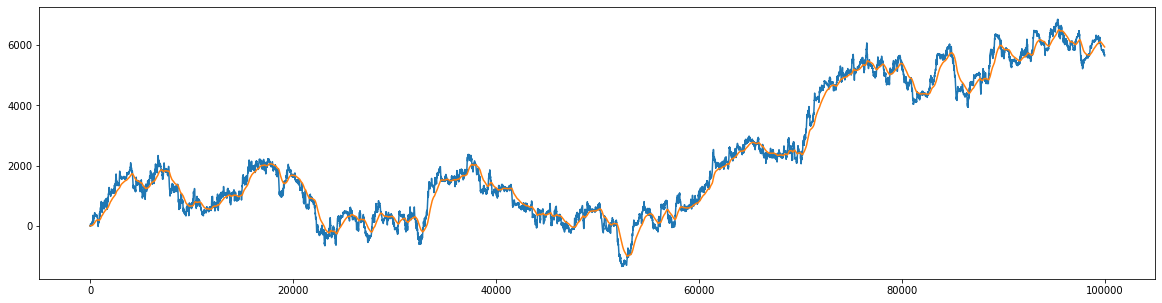

In [182]:
import random
def rando_data(length = 100):
    x = 0
    direction = 0
    deriv = 1
    deriv2 = 0
    result = []
    for _ in range(length):
        deriv = max(-1, min(deriv + random.random() - 0.5, 1)) if random.random() < 0.9 else - deriv
        # deriv = deriv + random.random() - 0.5 if random.random() < 0.9 else - deriv
        direction = max(-10, min(direction + random.random() * 2 - 1, 10)) if random.random() < 0.9 else - direction + deriv
        x += direction
        result.append(x)
    return result

fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
chart = rando_data(100000)
ax.plot(chart)
ax.plot(oraclize(chart, 1000))
    

In [168]:
sys.path.append("../..")
from model import run
from model import plot_utils as pu
from model.processing import import_binance_prices
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from datetime import datetime
import math

# same seed, same parameters = same simulation result
random.seed(42)
time_steps = len(price_per_block)

# get recorded market prices for the given time range
start_date=datetime.strptime(time_range[0], '%Y-%m-%dT%H:%M:%S.%fZ')
end_date=datetime.strptime(time_range[1], '%Y-%m-%dT%H:%M:%S.%fZ')
historical_price_data = import_binance_prices(
    assets=["DOT"],
    start_date=datetime.strftime(start_date, "%B %d %Y"),
    days=math.ceil((end_date - start_date).total_seconds() / (24 * 60 * 60))
)
assets = {
    'HDX': {'usd price': 0.0267, 'weight': 0.10},
    'DAI': {'usd price': 1, 'weight': 0.5},
    'DOT': {'usd price': price_per_block[0][1], 'weight': 0.4},
}

lrna_fee_amplification=1.0
lrna_fee_decay=0.000005
lrna_fee_min=0.0005
lrna_fee_max=0.001
asset_fee_amplification=0.5
asset_fee_decay=0.00001
asset_fee_min=0.0025
asset_fee_max=0.05

lrna_price_usd = 22.22222222
initial_omnipool_tvl = 1000000
liquidity = {}
lrna = {}
min_price = 0.00001

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'Omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            # lrna_fee=dynamicadd_lrna_fee(
            #     minimum=lrna_fee_min,
            #     amplification=lrna_fee_amplification,
            #     raise_oracle_name='fee_raise',
            #     decay=lrna_fee_decay,
            #     fee_max=lrna_fee_max,
            # ),
            # asset_fee=dynamicadd_asset_fee(
            #     minimum=asset_fee_min,
            #     amplification=asset_fee_amplification,
            #     raise_oracle_name='fee_raise',
            #     decay=asset_fee_decay,
            #     fee_max=asset_fee_max,
            # ),
            asset_fee=0,
            lrna_fee=0,
            oracles={'fee_raise': 20},
            preferred_stablecoin = 'DAI',
        )
    },
    agents={
        'Arbitrageur': Agent(
            holdings={tkn: 1000000000000 for tkn in list(assets.keys()) + ['LRNA']}, 
            trade_strategy=omnipool_arbitrage('Omnipool')
        )
    },
    evolve_function=historical_prices([{'DOT': line[1]} for line in price_per_block]),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)

In [169]:
events = [initial_state] + run.run(initial_state, time_steps-1)

Starting simulation...
Execution time: 3.261 seconds.


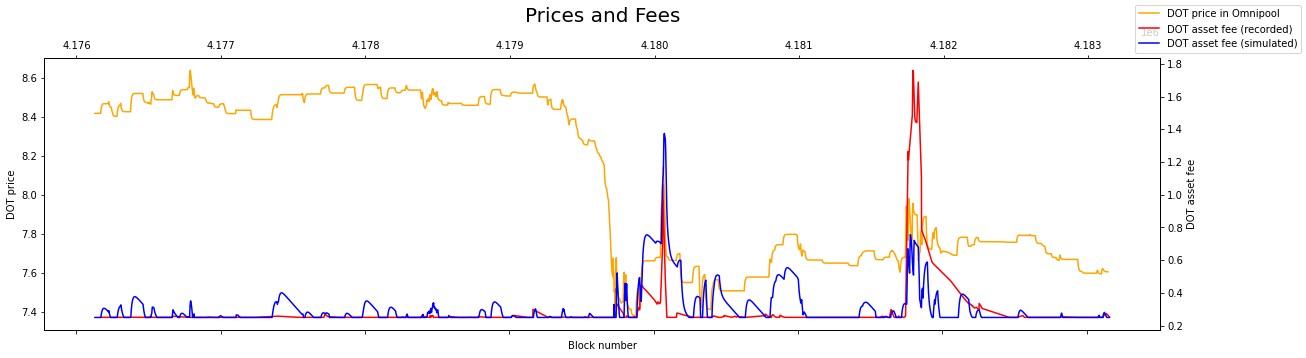

In [170]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    [line[0] for line in price_per_block], 
    oraclize([line[1] for line in price_per_block], 10), 
    color="orange",
    label="DOT price in Omnipool"
)
ax.set_ylabel("DOT price")
ax.set_xlabel("Block number")
# plt.gca().set_ylim([min(oracle_prices), max(oracle_prices)])

ax2 = ax.twinx()
ax2.plot(
    [line[1] for line in fee_data], 
    [float(line[3]) for line in fee_data], 
    color="red", 
    label="DOT asset fee (recorded)"
)
ax2.set_ylabel("DOT asset fee")
ax2.set(xticklabels=[])
# ax2.tick_params(axis='y', labelcolor="black")

asset_fee=dynamicadd_asset_fee(
    minimum=asset_fee_min,
    amplification=asset_fee_amplification,
    raise_oracle_name='fee_raise',
    decay=asset_fee_decay,
    fee_max=asset_fee_max,
)
for i in range(len(events) - 1):
    events[i + 1].pools['Omnipool'].last_fee = {'DOT': asset_fee.fee_function(events[i].pools['Omnipool'], 'DOT')}
ax3 = ax2.twiny()
ax3.plot(
    [line[0] for line in price_per_block], 
    [event.pools['Omnipool'].last_fee['DOT'] * 100 for event in events], 
    color="blue",
    label="DOT asset fee (simulated)"
)

# ax4 = ax.twiny()
# ax4.plot(
#     [usd_price(event.pools['Omnipool'], 'DOT') for event in events], 
#     color="orange",
#     label="DOT price (simulated)"
# )
# ax4.set(xticklabels=[])
# ax4.tick_params(top=False)

# ax5 = ax.twiny()
# ax5.plot(
#     [line['DOT'] for line in historical_price_data[:time_steps]], 
#     color="purple",
#     label="DOT price (Binance)"
# )
# ax5.set(xticklabels=[])
# ax5.tick_params(top=False)

plt.title("Prices and Fees", fontsize=20)
fig.legend(
    loc="upper right"
)
plt.show()

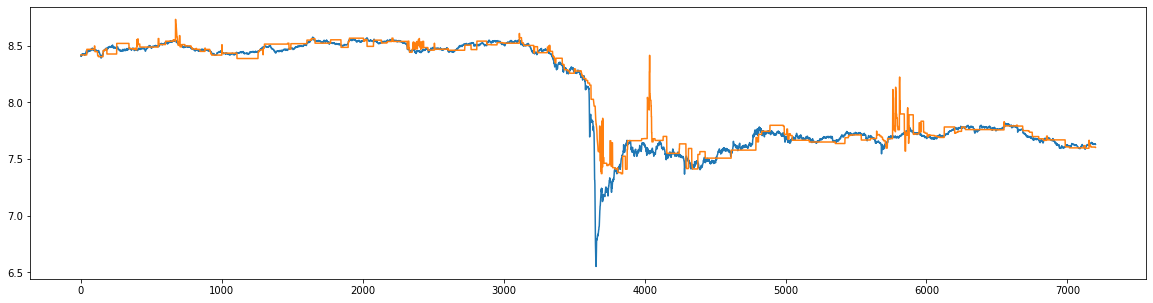

In [184]:
plt.figure(figsize=(20, 5))
plt.plot([line['DOT'] for line in price_data])
# plt.plot([price[1] for price in price_per_block])
plt.plot([i * len(price_data) / len(price_per_block) for i in range(len(price_per_block))], [price[1] for price in price_per_block])
plt.title("Historical Omnipool Dot price v

In [37]:
price_per_block[1000]

(4181628, 7.680728526079506)

5125

In [57]:
len(price_data), len(price_per_block)

(0, 5125)